# SEM-EDS zinc-soap dataset: clustering analysis

This notebook assumes you have already run 01_data_preparation.ipynb and have .hspy files saved in ./data_processed/.

Goals: 
- Build per-pixel feature vectors from integrated X-ray line intensities
- Optional background correction and simple transforms
- Dimensionality reduction with PCA
- Clustering (K-means baseline) plus basic validation (silhouette, stability sweep)
- Visualize spatial cluster maps and compare cluster-mean compositions

Figures are saved as PNG using the magma colormap by default. 

In [1]:
# Imports
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import hyperspy.api as hs

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Paths
OUT = Path("./data_processed")
FIGS = Path("./figures")
FIGS.mkdir(exist_ok=True)

# Plot defaults
plt.rcParams["figure.dpi"] = 120
DEFAULT_CMAP = "magma"

# Data products from 01_data_preparation.ipynb
AERIAL_HSPY = OUT / "Aerial 150x.hspy"
CS_HSPY = OUT / "CS 148x.hspy"

assert AERIAL_HSPY.exists(), f"Missing {AERIAL_HSPY}. Run 01_data_preparation.ipynb first."
assert CS_HSPY.exists(), f"Missing {CS_HSPY}. Run 01_data_preparation.ipynb first."

print("Ready.")

Ready.


## 1) Load saved .hspy datasets

In [2]:
sA = hs.load(AERIAL_HSPY)
sC = hs.load(CS_HSPY)

print("Aerial:", sA)
print("Cross-section:", sC)

C:\Users\elise\miniforge3\envs\zincsoap-ml\lib\site-packages\hyperspy\misc\_utils.py:1590: VisibleDeprecationWarning: Importing `LazyComplexSignal1D` from `hyperspy._signals.complex_signal1d` is deprecated and will be removed in the HyperSpy 3.0 release. Import it from `hyperspy.signals` instead.
  warnings.warn(
C:\Users\elise\miniforge3\envs\zincsoap-ml\lib\site-packages\hyperspy\misc\_utils.py:1590: VisibleDeprecationWarning: Importing `LazySignal1D` from `hyperspy._signals.signal1d` is deprecated and will be removed in the HyperSpy 3.0 release. Import it from `hyperspy.signals` instead.
  warnings.warn(
C:\Users\elise\miniforge3\envs\zincsoap-ml\lib\site-packages\hyperspy\misc\_utils.py:1590: VisibleDeprecationWarning: Importing `LazySignal1D` from `hyperspy._signals.signal1d` is deprecated and will be removed in the HyperSpy 3.0 release. Import it from `hyperspy.signals` instead.
  warnings.warn(


Aerial: <EDSSEMSpectrum, title: Aerial EDS Spectrum Image, dimensions: (1024, 600|3093)>
Cross-section: <EDSSEMSpectrum, title: Cross-section EDS Spectrum Image, dimensions: (1024, 648|3144)>


## 2) Feature extraction utilities
We represent each pixel by integrated line intensities (one feature per X-ray line).

In [4]:
XRAY_LINES = ("C_Ka", "O_Ka", "Cl_Ka", "S_Ka", "Zn_Ka", "Cd_La")

# Optional: background windows (keV) for specific lines, if you want to match an author workflow.
# Format: {line: [[lo1, hi1, lo2, hi2], ...]} with windows in keV.
BKG_WINDOWS = {
    # Example for Cl_Ka/Cl_Kb style windows; customize if needed.
    # "Cl_Ka": [[2.52, 2.56, 2.85, 2.92]],
}

def rebin_lazy(s, rebin_scale=(8,8,2)):
    """Lazy rebin with trimming so dimensions are divisible by the scale."""
    s = s.as_lazy()
    n0, n1 = s.axes_manager.navigation_shape
    ne = s.axes_manager.signal_shape[0]
    f0, f1, fe = rebin_scale
    s = s.inav[:n0 - (n0 % f0), :n1 - (n1 % f1)].isig[:ne - (ne % fe)]
    return s.rebin(scale=rebin_scale)

def get_line_maps(s_rb, xray_lines=XRAY_LINES, bkg_windows=None):
    """Return list of 2D line-intensity maps (HyperSpy signals)."""
    if bkg_windows:
        # HyperSpy expects background_windows as an (n_lines, 4) array, so we build it when provided.
        lines = []
        windows = []
        for ln in xray_lines:
            if ln in bkg_windows:
                lines.append(ln)
                windows.append(bkg_windows[ln][0])
        if lines:
            bw = np.array(windows, dtype=float)
            maps = s_rb.get_lines_intensity(xray_lines=list(lines), background_windows=bw, plot_result=False)
            # For lines without windows, fall back to default integration
            remaining = [ln for ln in xray_lines if ln not in lines]
            if remaining:
                maps2 = s_rb.get_lines_intensity(xray_lines=remaining, plot_result=False)
                maps = list(maps) + list(maps2)
            return maps
    return s_rb.get_lines_intensity(xray_lines=list(xray_lines), plot_result=False)

def maps_to_X(maps, dtype=np.float32):
    """Stack flattened maps into (n_pixels, n_features)."""
    cols = [np.asarray(m.data, dtype=dtype).ravel() for m in maps]
    return np.column_stack(cols)

def counts_mask_from_spectrum_image(s_rb, quantile=0.05):
    """Mask low-count pixels using total counts; returns keep mask (flat) and mask2d."""
    tc = np.asarray(s_rb.sum(axis=s_rb.axes_manager.signal_indices_in_array).data)
    thresh = np.quantile(tc, quantile)
    mask2d = tc > thresh
    return mask2d.ravel(), mask2d, tc

def apply_transform(X, transform="none"):
    if transform == "none":
        return X
    if transform == "log1p":
        return np.log1p(np.clip(X, 0, None))
    raise ValueError(f"Unknown transform: {transform}")

## 3) End-to-end pipeline

In [5]:
def run_kmeans_pipeline(
    s,
    rebin_scale=(8,8,2),
    xray_lines=XRAY_LINES,
    bkg_windows=None,
    counts_mask_quantile=0.05,
    transform="log1p",
    n_pca=6,
    k=4,
    random_state=0,
):
    # Rebin
    s_rb = rebin_lazy(s, rebin_scale=rebin_scale)

    # Feature maps -> X
    maps = get_line_maps(s_rb, xray_lines=xray_lines, bkg_windows=bkg_windows)
    X = maps_to_X(maps)

    # Mask background
    keep, keep2d, tc = counts_mask_from_spectrum_image(s_rb, quantile=counts_mask_quantile)

    # Optional transform
    Xt = apply_transform(X, transform=transform)

    # Scale
    scaler = StandardScaler()
    Z = scaler.fit_transform(Xt[keep])

    # PCA (for diagnostics/plots; clustering uses Z directly here)
    pca = PCA(n_components=min(n_pca, Z.shape[1]), random_state=random_state)
    P = pca.fit_transform(Z)

    # K-means
    km = KMeans(n_clusters=k, random_state=random_state, n_init="auto")
    labels = km.fit_predict(Z)

    # Validation
    sil = silhouette_score(Z, labels) if k > 1 and len(np.unique(labels)) > 1 else np.nan

    return {
        "s_rb": s_rb,
        "maps": maps,
        "X": X,
        "Xt": Xt,
        "keep": keep,
        "keep2d": keep2d,
        "total_counts": tc,
        "scaler": scaler,
        "pca": pca,
        "scores_pca": P,
        "kmeans": km,
        "labels_keep": labels,
        "silhouette": sil,
        "xray_lines": tuple(xray_lines),
        "rebin_scale": tuple(rebin_scale),
        "transform": transform,
        "k": k,
    }

## 4) Run baseline analysis for Aerial and Cross-section

In [6]:
resA = run_kmeans_pipeline(sA, k=4, transform="log1p")
resC = run_kmeans_pipeline(sC, k=4, transform="log1p")

print("Aerial silhouette:", resA["silhouette"])
print("CS silhouette    :", resC["silhouette"])
print("Aerial PCA EVR   :", resA["pca"].explained_variance_ratio_)
print("CS PCA EVR       :", resC["pca"].explained_variance_ratio_)

C:\Users\elise\miniforge3\envs\zincsoap-ml\lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


Aerial silhouette: 0.4942723512649536
CS silhouette    : 0.26394686102867126
Aerial PCA EVR   : [0.67923284 0.14476804 0.10978623 0.03877931 0.01407053 0.01336301]
CS PCA EVR       : [0.70719945 0.11624532 0.09364917 0.04734873 0.02010367 0.01545371]


## 5) Visualize line maps and cluster maps

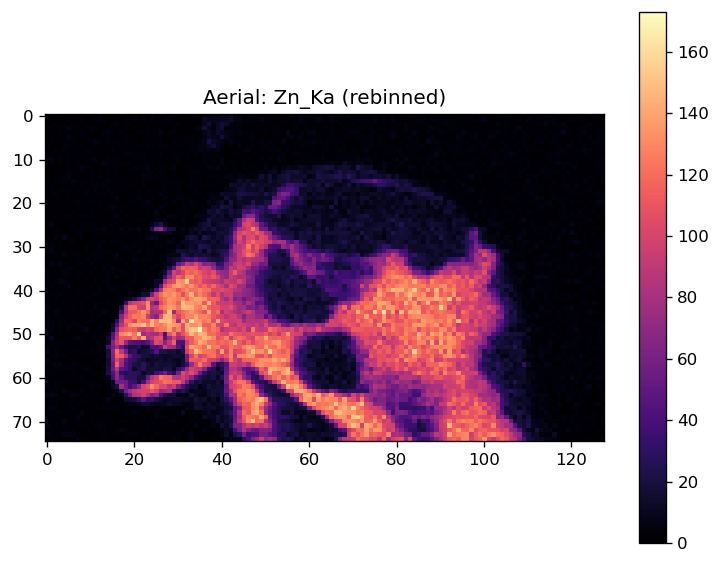

Saved: figures\Aerial_Zn_Ka.png


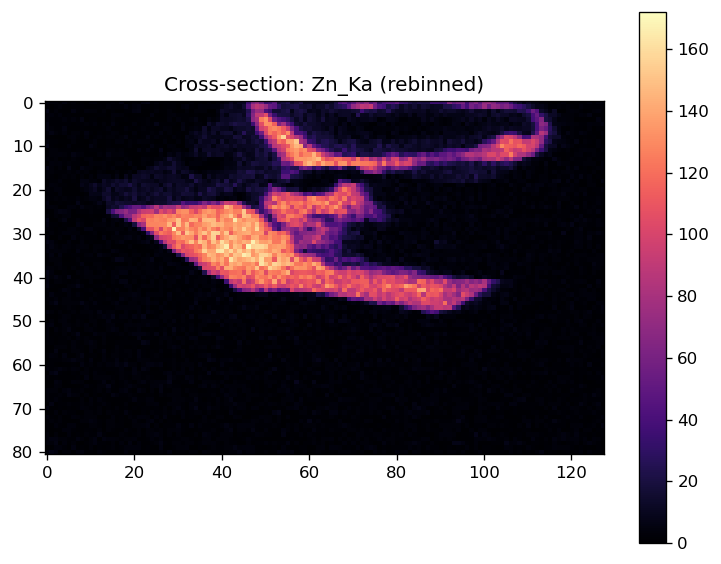

Saved: figures\CS_Zn_Ka.png


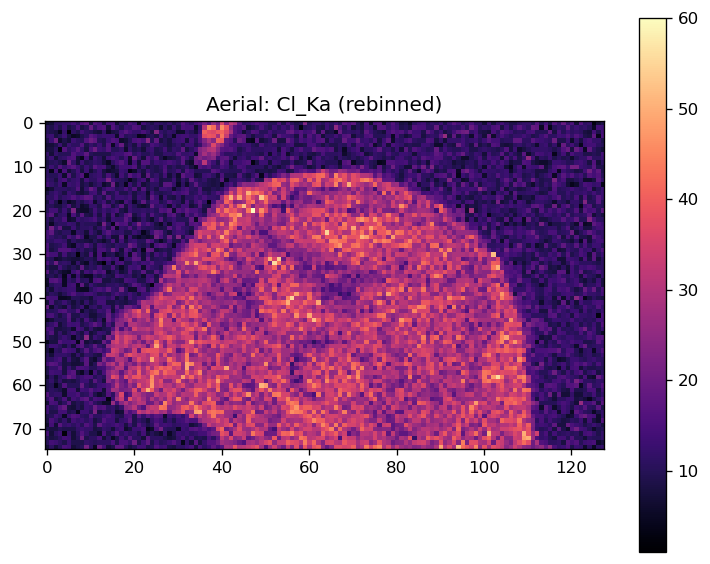

Saved: figures\Aerial_Cl_Ka.png


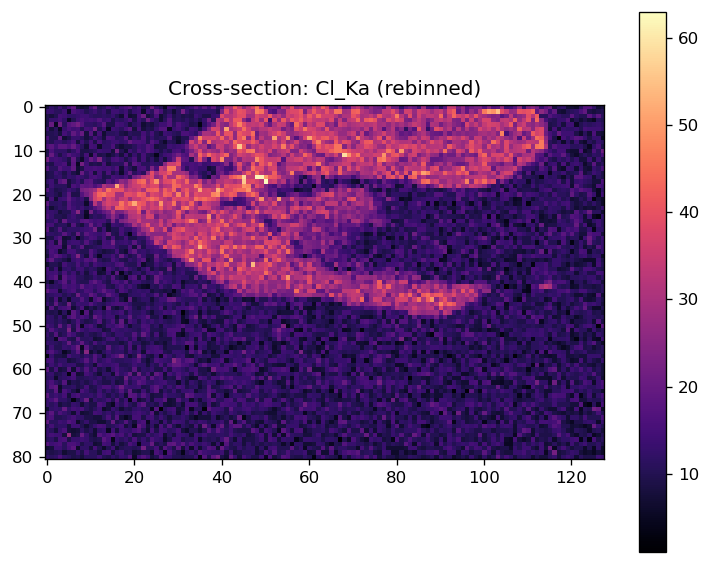

Saved: figures\CS_Cl_Ka.png


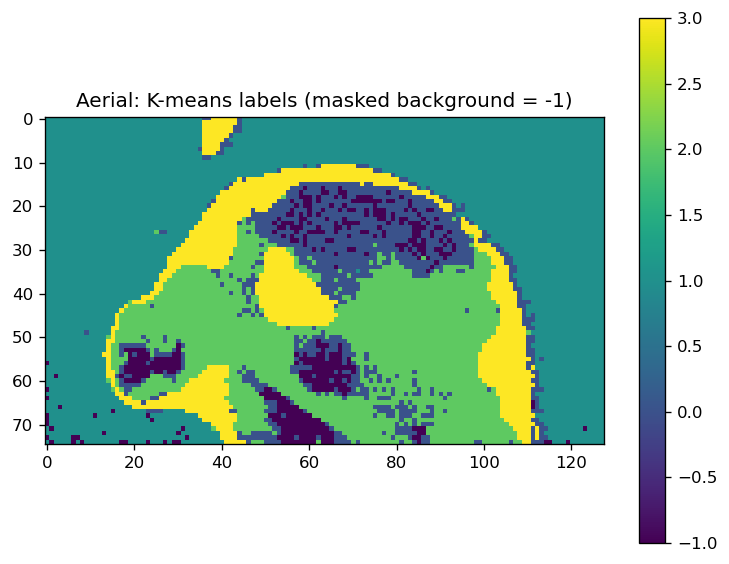

Saved: figures\Aerial_kmeans_labels.png


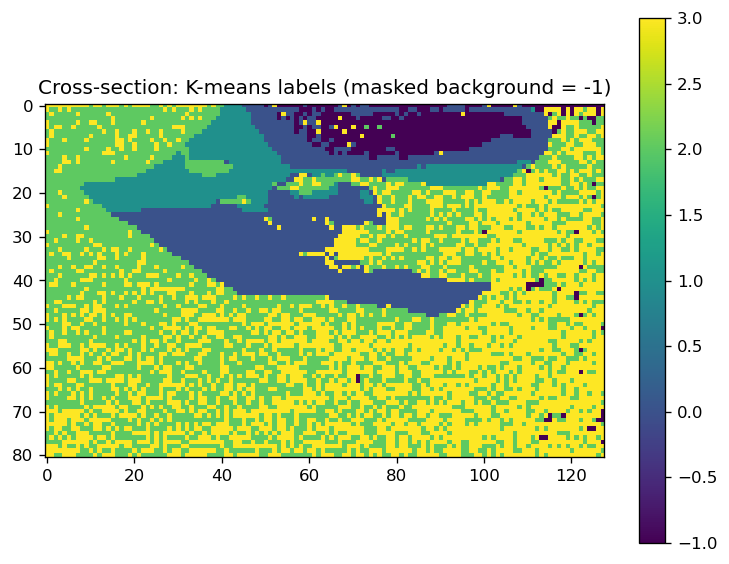

Saved: figures\CS_kmeans_labels.png


In [8]:
def save_imshow(arr2d, title, outpath, cmap=DEFAULT_CMAP):
    plt.figure()
    plt.imshow(arr2d, cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.savefig(outpath, dpi=300)
    plt.show()
    print("Saved:", outpath)

def labels_to_map(labels_keep, keep2d, fill_value=-1):
    lab_full = np.full(keep2d.size, fill_value, dtype=int)
    lab_full[keep2d.ravel()] = labels_keep
    return lab_full.reshape(keep2d.shape)

# Example quick maps (Zn and Cl)
for line in ("Zn_Ka", "Cl_Ka"):
    idxA = resA["xray_lines"].index(line)
    idxC = resC["xray_lines"].index(line)

    mA = resA["maps"][idxA].data
    mC = resC["maps"][idxC].data

    save_imshow(mA, f"Aerial: {line} (rebinned)", FIGS / f"Aerial_{line}.png")
    save_imshow(mC, f"Cross-section: {line} (rebinned)", FIGS / f"CS_{line}.png")

# Cluster maps
labA_map = labels_to_map(resA["labels_keep"], resA["keep2d"])
labC_map = labels_to_map(resC["labels_keep"], resC["keep2d"])

save_imshow(labA_map, "Aerial: K-means labels (masked background = -1)", FIGS / "Aerial_kmeans_labels.png", cmap=None)
save_imshow(labC_map, "Cross-section: K-means labels (masked background = -1)", FIGS / "CS_kmeans_labels.png", cmap=None)

## 6) Cluster-mean composition (for interpretation)

In [9]:
def cluster_means(X_keep, labels_keep):
    labs = np.unique(labels_keep)
    out = np.vstack([X_keep[labels_keep == lab].mean(axis=0) for lab in labs])
    return labs, out

labsA, meansA = cluster_means(resA["Xt"][resA["keep"]], resA["labels_keep"])
labsC, meansC = cluster_means(resC["Xt"][resC["keep"]], resC["labels_keep"])

print("Lines:", resA["xray_lines"])
print("Aerial means (rows = cluster label):")
for lab, row in zip(labsA, meansA):
    print(lab, row)

print("\nCross-section means (rows = cluster label):")
for lab, row in zip(labsC, meansC):
    print(lab, row)

Lines: ('C_Ka', 'O_Ka', 'Cl_Ka', 'S_Ka', 'Zn_Ka', 'Cd_La')
Aerial means (rows = cluster label):
0 [6.0113792 4.459195  3.2847407 3.4861546 3.1066246 2.997085 ]
1 [6.6952806 4.568434  2.4985766 2.6849685 1.158793  2.4276357]
2 [5.600466  4.8217416 3.4002964 3.413606  4.5932646 3.3027687]
3 [5.646947  4.7950873 3.4742482 4.953989  2.889992  5.2210608]

Cross-section means (rows = cluster label):
0 [5.857415  4.6861095 3.3876457 3.4303641 4.382487  3.281455 ]
1 [5.8022933 4.8268495 3.5105708 5.002941  2.65219   5.2662654]
2 [6.7667837 4.596806  2.565864  2.6958408 1.1691014 2.416125 ]
3 [6.738378  4.4080462 2.4382374 2.640398  1.1741146 2.3393242]


## 7) Quick k-sweep (silhouette + stability)

This is a lightweight way to compare values of k without overcomplication the notebook.

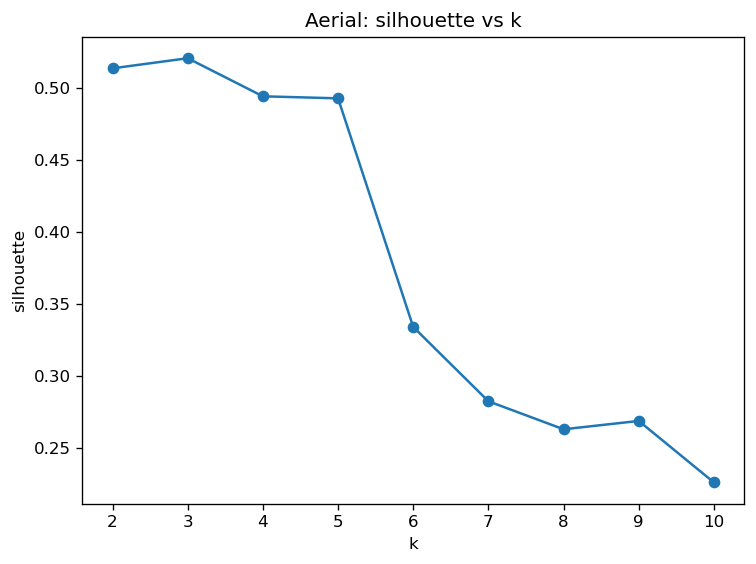

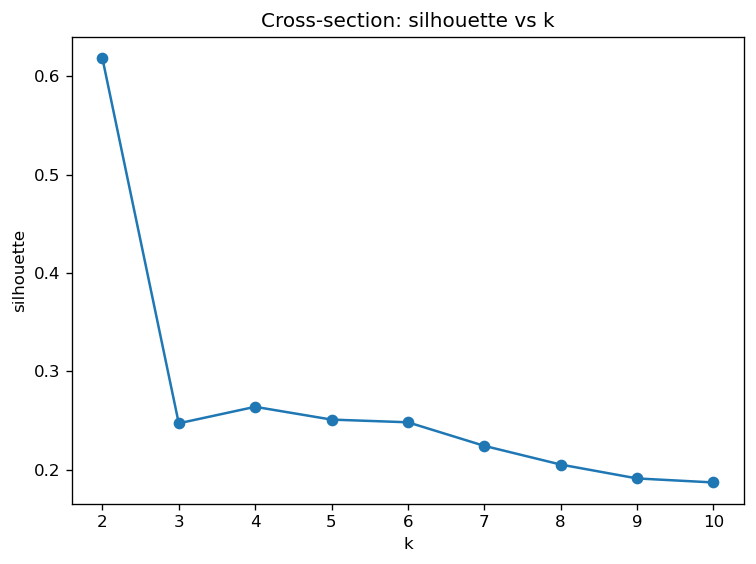

In [10]:
def k_sweep(res_base, k_list=range(2,9), random_state=0):
    Z = res_base["scaler"].fit_transform(res_base["Xt"][res_base["keep"]])
    out = []
    for k in k_list:
        km = KMeans(n_clusters=k, random_state=random_state, n_init="auto")
        labels = km.fit_predict(Z)
        sil = silhouette_score(Z, labels)
        out.append((k, sil))
    return np.array(out)

ksA = k_sweep(resA, k_list=range(2,11))
ksC = k_sweep(resC, k_list=range(2,11))

plt.figure()
plt.plot(ksA[:,0], ksA[:,1], marker="o")
plt.title("Aerial: silhouette vs k")
plt.xlabel("k")
plt.ylabel("silhouette")
plt.tight_layout()
plt.savefig(FIGS / "Aerial_silhouette_vs_k.png", dpi=300)
plt.show()

plt.figure()
plt.plot(ksC[:,0], ksC[:,1], marker="o")
plt.title("Cross-section: silhouette vs k")
plt.xlabel("k")
plt.ylabel("silhouette")
plt.tight_layout()
plt.savefig(FIGS / "CS_silhouette_vs_k.png", dpi=300)
plt.show()

## Notes / next steps
- Keep editing above code (add axes, fix background noise in CS)
- Create a results table
- Add a second clustering method (GMM or hierarchical) for comparison
- Compare background-corrected vs uncorrected line integration
- Add cluster stability across random seeds (adjusted Rand index) for a more formal robustness measure